# Learn world 3
* 27/10
* Try to make an ESN learn some world3 dynamics with a delay, and see what happends when we try different scenarios 

## Create data
We can take agricultrual input and land fertility degradation, there is a delay as shown p275 of Dynamics of Growth in a finite world

In [2]:
# imports
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

# Put git on branch main !
world3_path = "/home/achille/Bureau/couillet/world3/pyworld3/pyworld3"
if world3_path not in sys.path:
    sys.path.append(world3_path)
from pyworld3 import World3
from pyworld3.utils import plot_world_with_scales, variable_definitions

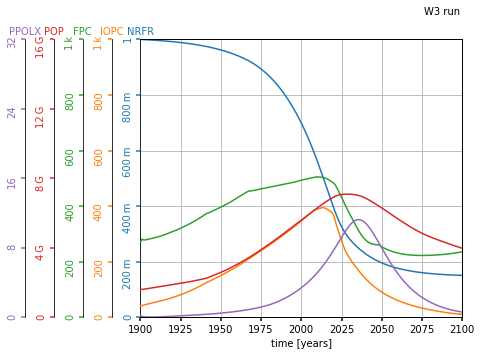

In [3]:
# Run
w = World3(dt=1)
w.init_world3_constants()
w.init_world3_variables()
w.set_world3_table_functions()
w.set_world3_delay_functions()
w.run_world3()
plot_world_with_scales(w)

## Additional functions

In [4]:
# Random functions for internal weights
def rand_W_sample(size, cst=0.4, scarcity=0.6):
    probs = [scarcity, (1-scarcity)/2, (1-scarcity)/2]
    Wr = np.random.choice([0, -cst, cst], size=size, replace=True, p=probs)
    try:
        return Wr/max(abs(np.linalg.eigvals(Wr)))
    except:
        print('NORM bc not squared matrix')
        return Wr/np.linalg.norm(Wr)

def rand_W_unif(size, cst=0.4, scarcity=0.6):
    Wr = np.random.sample(size)*2*cst - cst
    mask = np.random.choice([0, 1], size=size, replace=True, p=[scarcity, 1-scarcity])
    Wr = mask*Wr
    return Wr/max(abs(np.linalg.eigvals(Wr)))
    
def rand_W_normal(size, var=1, scarcity=0.6):
    Wr = np.random.normal(0, var, size=size)
    mask = np.random.choice([0, 1], size=size, replace=True, p=[scarcity, 1-scarcity])
    Wr = mask*Wr
    return Wr/max(abs(np.linalg.eigvals(Wr)))


# One input, one output

ai : agricultural inputs [dollars/year].
lfd : land fertility degradation
[vegetable-equivalent kilograms/hectare-year-year].


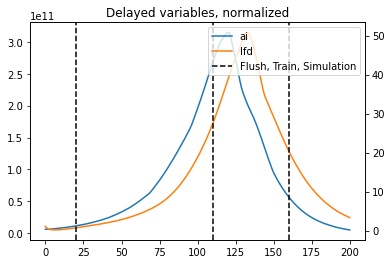

In [33]:
# Choose data and parameters
x_name, y_name = 'ai','lfd'
Fl = 20
Tr = 90
Si = 50
Tt = Fl + Tr + Si


x, y = w.__getattribute__(x_name), w.__getattribute__(y_name)
X, Y = x[:Tt]/np.linalg.norm(x[:Tt]), y[:Tt]/np.linalg.norm(y[:Tt])

# Plot what is chosen
fig = plt.figure()
plot1 = fig.add_subplot(title="Delayed variables, normalized")
plot2 = plot1.twinx()
plot1.plot(x, label=x_name)
plot2.plot(y, color='tab:orange', label=y_name);
plot2.axvline(x=Fl, color='black', linestyle='--', label = 'Flush, Train, Simulation')
plot2.axvline(x=Fl+Tr, color='black', linestyle='--')
plot2.axvline(x=Fl+Tr+Si, color='black', linestyle='--')
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=plot1.transAxes)
print(x_name, ':', variable_definitions[x_name])
print(y_name, ':', variable_definitions[y_name])


## ESN

In [34]:
# Parametrs
## Neurons number
K = 1
N = 20
L = 1

## Activation functions
f_dr = lambda x: x
f_out = lambda x: x
inv_f_out = lambda x: x

## Other
r = 0.95 # Spectral radius
var_noise = 0.00001 # Variance of random noise

In [35]:
# Random functions for internal weights
def rand_W_sample(size, cst=0.4, scarcity=0.6):
    probs = [scarcity, (1-scarcity)/2, (1-scarcity)/2]
    Wr = np.random.choice([0, -cst, cst], size=size, replace=True, p=probs)
    try:
        return Wr/max(abs(np.linalg.eigvals(Wr)))
    except:
        print('NORM bc not squared matrix')
        return Wr/np.linalg.norm(Wr)

def rand_W_unif(size, cst=0.4, scarcity=0.6):
    Wr = np.random.sample(size)*2*cst - cst
    mask = np.random.choice([0, 1], size=size, replace=True, p=[scarcity, 1-scarcity])
    Wr = mask*Wr
    return Wr/max(abs(np.linalg.eigvals(Wr)))
    
def rand_W_normal(size, var=1, scarcity=0.6):
    Wr = np.random.normal(0, var, size=size)
    mask = np.random.choice([0, 1], size=size, replace=True, p=[scarcity, 1-scarcity])
    Wr = mask*Wr
    return Wr/max(abs(np.linalg.eigvals(Wr)))


In [36]:
# Weights
W_in = rand_W_sample((N,K), scarcity=0)

# W_back = rand_W_sample((N,L), scarcity=0)

param_rand_W = 0.4
scarcity = 0.9
rand_W = rand_W_sample
W = rand_W((N,N), param_rand_W, scarcity)*r

NORM bc not squared matrix


In [37]:
# Sample
data = np.vstack((X,Y)).T
io_data = np.array([inv_f_out(d) for d in data]) # Inverse out data

M = np.zeros((Tt, N))
# M # INIT if you want
for i in range(1, Fl + Tr):
    noise = np.random.normal(0, var_noise, size=N)
#     M[i,:] = f_dr(np.dot(W, M[i-1,:]) + np.dot(W_back, io_data[i-1,:]) + noise) # back output version
    M[i,:] = f_dr(np.dot(W, M[i-1,:]) + np.dot(W_in, io_data[i-1,:K]) + noise)

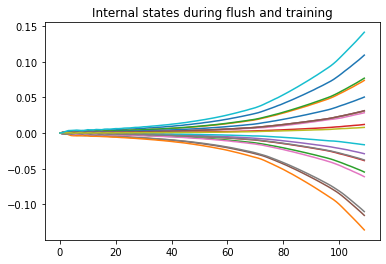

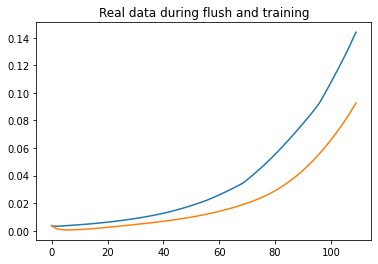

In [38]:
# Plot internal states
plt.plot(M[: Fl + Tr]);
plt.title("Internal states during flush and training");
plt.figure()
plt.plot(io_data[: Fl + Tr]);
plt.title("Real data during flush and training");

In [39]:
# Learn
W_out = np.dot(np.linalg.pinv(M[Fl: Fl + Tr]), io_data[Fl: Fl + Tr,-L:])

Text(0.5, 1.0, 'Real and trained data')

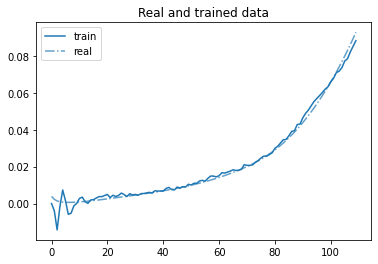

In [40]:
# Plot learned
plt.gca().set_prop_cycle(color=[plt.get_cmap("tab10")(i) for i in range(K)])
plt.plot(np.dot(M[: Fl + Tr], W_out), label='train');
plt.plot(io_data[: Fl + Tr,-L:], linestyle='-.', alpha=0.7, label='real')
plt.legend()
plt.title("Real and trained data")

## Simulation part
Run several simulations with different inputs and plot results

In [41]:
# Simulate with real input
name1 = 'With real input'
input1 = io_data[:,:K].copy()
M1 = M.copy()
Z1 = np.zeros((Tt, L))
Z1[: Fl + Tr,:] = np.dot(M1[: Fl + Tr], W_out)
for i in range(Fl + Tr, Tt):
    M1[i] = f_dr(np.dot(W, M1[i-1,:]) + np.dot(W_in, input1[i-1]))
    Z1[i] = f_out(np.dot(M1[i,:], W_out))

In [42]:
# Simulate with 0 input
zero_date = Fl + Tr + 20
name2 = f'With 0 input after {zero_date} date'
input2 = io_data[:,:K].copy()
input2[zero_date:] = 0
Z2 = np.zeros((Tt, L))
M2 = M.copy()
Z2[: Fl + Tr,:] = np.dot(M[: Fl + Tr], W_out)
for i in range(Fl + Tr, Tt):
    M2[i] = f_dr(np.dot(W, M2[i-1,:]) + np.dot(W_in, input2[i-1]))
    Z2[i] = f_out(np.dot(M2[i,:], W_out))

In [43]:
# Simulate with input fixed after certain date
fixed_date = Fl + Tr + 20
name3 = f'With fixed input after {fixed_date} date'
input3 = io_data[:,:K].copy()
input3[fixed_date:] = io_data[fixed_date,:K]
Z3 = np.zeros((Tt, L))
M3 = M.copy()
Z3[: Fl + Tr,:] = np.dot(M[: Fl + Tr], W_out)
for i in range(Fl + Tr, Tt):
    M3[i] = f_dr(np.dot(W, M3[i-1,:]) + np.dot(W_in, input3[i-1]))
    Z3[i] = f_out(np.dot(M3[i,:], W_out))

In [46]:
# Simulate with input fixed after certain date
grow_date = Fl + Tr
name4 = f'Continue to grow at {grow_date} date rate'
input4 = io_data[:,:K].copy()
coef = io_data[grow_date,:K] - io_data[grow_date-1,:K]
input4[grow_date:] = np.array([io_data[grow_date,:K]+coef*np.arange(Tt-grow_date)]).T
Z4 = np.zeros((Tt, L))
M4 = M.copy()
Z4[: Fl + Tr,:] = np.dot(M[: Fl + Tr], W_out)
for i in range(Fl + Tr, Tt):
    M4[i] = f_dr(np.dot(W, M4[i-1,:]) + np.dot(W_in, input4[i-1]))
    Z4[i] = f_out(np.dot(M4[i,:], W_out))

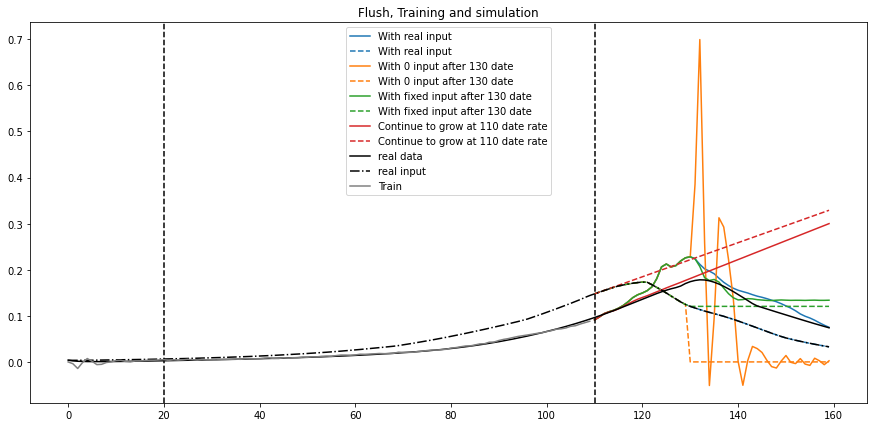

In [47]:
# Plot simulation vs real
plt.subplots(figsize=(15,7))
coldef = [plt.get_cmap("tab10")(i) for i in range(10)]
plt.gca().set_prop_cycle(color=[coldef[i] for i in range(4) for j in range(2)])

for inputi, namei, Zi in [(input1, name1, Z1),
                        (input2, name2, Z2),
                        (input3, name3, Z3),
                         (input4, name4, Z4)]:
    plt.plot(range(Fl+Tr, Tt), Zi[Fl+Tr:], label = namei);
    plt.plot(range(Fl+Tr, Tt), inputi[Fl+Tr:], label=namei, linestyle='--');

plt.plot(data[:Tt,-L:], label='real data', color='black')
plt.axvline(Fl + Tr, linestyle='--', color='black');
plt.axvline(Fl, linestyle='--', color='black');
# plt.legend(['output x', 'output y', 'real x', 'real y'])
plt.title("Flush, Training and simulation")
plt.plot(data[:,:K], label='real input', linestyle='-.',color='black')
plt.plot(np.dot(M[: Fl + Tr], W_out), label='Train', color='gray')
plt.legend()    

#  ------------ Multi inputs and outputs -----------

In [275]:
w.ones = np.ones(len(w.time))
# Choose data and parameters
x_names, y_names = ['ones', 'iopc'], ['lfd', 'ai' ,'ppolx', 'pop']

Fl = 30
Tr = 90
Si = len(w.pop) - Fl - Tr
Tt = Fl + Tr + Si

X = np.vstack([x[:Tt]/np.linalg.norm(x[:Tt]) for x in (w.__getattribute__(x_name) for x_name in x_names)])
Y = np.vstack([y[:Tt]/np.linalg.norm(y[:Tt]) for y in (w.__getattribute__(y_name) for y_name in y_names)])

iopc : industrial output per capita [dollars/person-year].
lfd : land fertility degradation
[vegetable-equivalent kilograms/hectare-year-year].
ai : agricultural inputs [dollars/year].
ppolx : index of persistent pollution [].
pop : population [persons].


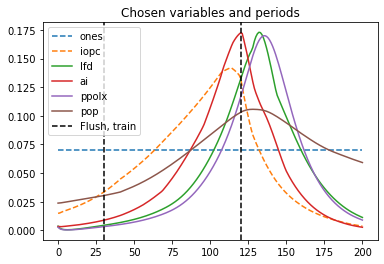

In [276]:
# Plot what is chosen
fig = plt.figure()
plot1 = fig.add_subplot(title="Chosen variables and periods")
plt.plot(X.T, linestyle = '--')
plt.plot(Y.T, linestyle='-')
plt.axvline(x=Fl, color='black', linestyle='--')
plt.axvline(x=Fl+Tr, color='black', linestyle='--')
# plt.axvline(x=Fl+Tr+Si, color='black', linestyle='--')
plt.legend(x_names + y_names +['Flush, train'])
for x_name in x_names:
    if x_name not in {'zeros', 'ones'}:
        print(x_name, ':', variable_definitions[x_name])
for y_name in y_names:
    print(y_name, ':', variable_definitions[y_name])

## ESN

In [277]:
# Parametrs
## Neurons number
K = len(x_names)
N = 20
L = len(y_names)

## Activation functions
f_dr = lambda x: np.tanh(x)
f_out = lambda x: x
inv_f_out = lambda x: x

## Other
r = 0.95 # Spectral radius
var_noise = 0.00001 # Variance of random noise

In [278]:
# Weights
W_in = rand_W_sample((N,K), scarcity=0)

W_back = rand_W_sample((N,L), scarcity=0)

param_rand_W = 0.4
scarcity = 0.9
rand_W = rand_W_sample
W = rand_W((N,N), param_rand_W, scarcity)*r

NORM bc not squared matrix
NORM bc not squared matrix


In [279]:
# Sample
data = np.vstack((X,Y)).T
io_data = np.array([inv_f_out(d) for d in data]) # Inverse out data

M = np.zeros((Tt, N))
# M # INIT if you want
for i in range(1, Fl + Tr):
    noise = np.random.normal(0, var_noise, size=N)
#     M[i,:] = f_dr(np.dot(W, M[i-1,:]) + np.dot(W_back, io_data[i-1,:]) + noise) # back output version
    M[i,:] = f_dr(np.dot(W, M[i-1,:]) + np.dot(W_in, io_data[i-1,:K]) + np.dot(W_back, io_data[i-1,-L:]) + noise)

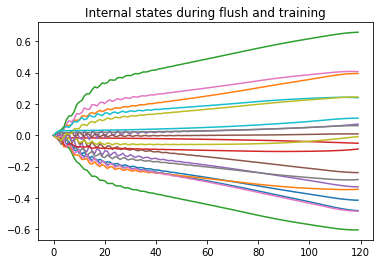

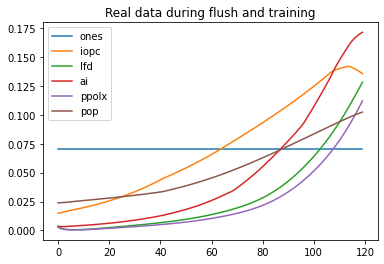

In [280]:
# Plot internal states
plt.plot(M[: Fl + Tr]);
plt.title("Internal states during flush and training");
plt.figure()
plt.plot(io_data[: Fl + Tr]);
plt.legend(x_names + y_names)
plt.title("Real data during flush and training");

In [281]:
# Learn
W_out = np.dot(np.linalg.pinv(M[Fl: Fl + Tr]), io_data[Fl: Fl + Tr,-L:])

Text(0.5, 1.0, 'Real and trained data')

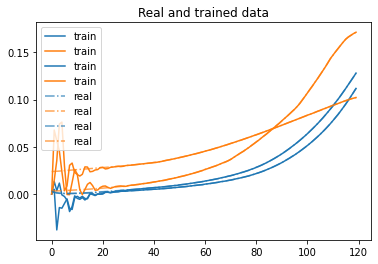

In [282]:
# Plot learned
plt.gca().set_prop_cycle(color=[plt.get_cmap("tab10")(i) for i in range(K)])
plt.plot(np.dot(M[: Fl + Tr], W_out), label='train');
plt.plot(io_data[: Fl + Tr,-L:], linestyle='-.', alpha=0.7, label='real')
plt.legend()
plt.title("Real and trained data")

## Simulation part
Run several simulations with different inputs and plot results

In [283]:
change_input_date = Fl + Tr + 10

In [284]:
# Simulate with real input
name1 = 'With real input'
input1 = io_data[:,:K].copy()
M1 = M.copy()
Z1 = np.zeros((Tt, L))
Z1[: Fl + Tr,:] = np.dot(M1[: Fl + Tr], W_out)
for i in range(Fl + Tr, Tt):
    M1[i] = f_dr(np.dot(W, M1[i-1,:]) + np.dot(W_in, input1[i-1]) + np.dot(W_back, Z1[i-1]))
    Z1[i] = f_out(np.dot(M1[i,:], W_out))

## JUST REAL INPUT

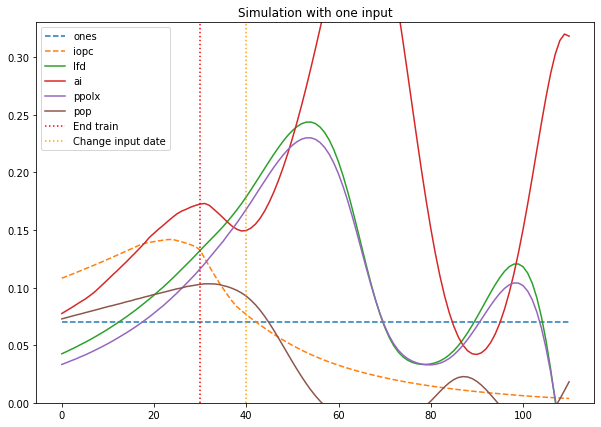

In [285]:
history_len = 30
fig, axes = plt.subplots(1, 1, figsize = (10, 7))
ax = axes
ax.plot(input1[Fl + Tr - history_len:], linestyle='--');
ax.plot(Z1[Fl + Tr - history_len:]);
ax.axvline(history_len, linestyle=':', color='red');
ax.axvline(change_input_date - Fl - Tr +history_len, linestyle=':', color='orange');
ax.set_title("Simulation with one input")
ax.set_ylim([0, 2*io_data[change_input_date-1].max()])
ax.legend(x_names + y_names + ['End train', 'Change input date']);
# ax.plot(range(history_len, history_len + Tt - Fl - Tr), io_data[Fl + Tr :, -L:], color='black')

In [286]:
# Simulate with 0 input
zero_date = change_input_date
name2 = f'With 0 input after {zero_date} date'
input2 = io_data[:,:K].copy()
input2[zero_date:] = 0
Z2 = np.zeros((Tt, L))
M2 = M.copy()
Z2[: Fl + Tr,:] = np.dot(M[: Fl + Tr], W_out)
for i in range(Fl + Tr, Tt):
    M2[i] = f_dr(np.dot(W, M2[i-1,:]) + np.dot(W_in, input2[i-1]) + np.dot(W_back, Z2[i-1]))
    Z2[i] = f_out(np.dot(M2[i,:], W_out))

In [287]:
# Simulate with input fixed after certain date
fixed_date = change_input_date
name3 = f'With fixed input after {fixed_date} date'
input3 = io_data[:,:K].copy()
input3[fixed_date:] = io_data[fixed_date,:K]
Z3 = np.zeros((Tt, L))
M3 = M.copy()
Z3[: Fl + Tr,:] = np.dot(M[: Fl + Tr], W_out)
for i in range(Fl + Tr, Tt):
    M3[i] = f_dr(np.dot(W, M3[i-1,:]) + np.dot(W_in, input3[i-1]) + np.dot(W_back, Z3[i-1]))
    Z3[i] = f_out(np.dot(M3[i,:], W_out))

In [288]:
# Simulate with input fixed after certain date
grow_date = change_input_date
name4 = f'Continue to grow at {grow_date} date rate'
input4 = io_data[:,:K].copy()
coef = io_data[grow_date,:K] - io_data[grow_date-1,:K]
input4[grow_date:] = np.outer(np.arange(Tt-grow_date), coef) + io_data[grow_date,:K]
Z4 = np.zeros((Tt, L))
M4 = M.copy()
Z4[: Fl + Tr,:] = np.dot(M[: Fl + Tr], W_out)
for i in range(Fl + Tr, Tt):
    M4[i] = f_dr(np.dot(W, M4[i-1,:]) + np.dot(W_in, input4[i-1]) + np.dot(W_back, Z4[i-1]))
    Z4[i] = f_out(np.dot(M4[i,:], W_out))

## TRY DIFFERENT INPUTS

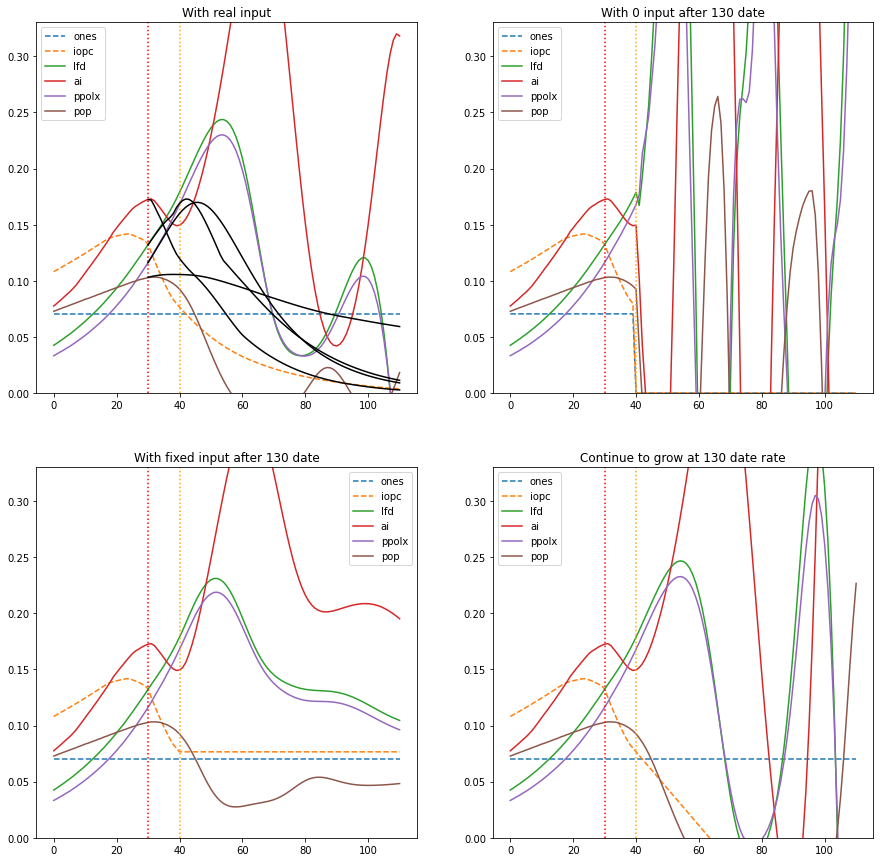

In [289]:
history_len = 30
fig, axes = plt.subplots(2, 2, figsize = (15, 15))
for (inputi, namei, Zi), ax in zip([(input1, name1, Z1),
                        (input2, name2, Z2),
                        (input3, name3, Z3),
                        (input4, name4, Z4)], axes.flatten()):
    ax.plot(inputi[Fl + Tr - history_len:], linestyle='--');
    ax.plot(Zi[Fl + Tr - history_len:]);
    ax.axvline(history_len, linestyle=':', color='red');
    ax.axvline(change_input_date - Fl - Tr +history_len, linestyle=':', color='orange');
    ax.set_title(namei)
    ax.set_ylim([0, 2*io_data[change_input_date-1].max()])
    ax.legend(x_names + y_names)
    if namei == name1:
        ax.plot(range(history_len, history_len + Tt - Fl - Tr), io_data[Fl + Tr :, -L:], color='black')
#         ax.legend(x_names + y_names + ['End train', 'Change input date', 'Real output'])

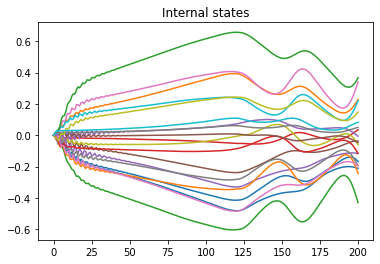

In [290]:
# Plot internal states
plt.plot(M1);
plt.title("Internal states");